In [1]:
import skimage
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from scipy.optimize import curve_fit
from matplotlib import rcParams
from statsmodels.stats.weightstats import ttest_ind
from statannotations.Annotator import Annotator
rcParams['figure.dpi'] = 250
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 20

In [15]:
class Plate():

    def __init__(self, data_dir, analysis_name):
        self.data_dir = data_dir
        self.analysis_name = analysis_name
        self._load_data()
        self._load_platemap()

    def _load_data(self):
            
        self.image_data = pd.read_csv(self.data_dir / 
                                self.analysis_name /
                                (self.analysis_name + 'Image.csv'))
        self.soma_data = pd.read_csv(self.data_dir / 
                                self.analysis_name /
                                (self.analysis_name + 'cytoplasm_outlines.csv'))
        self.nuclei_data = pd.read_csv(self.data_dir / 
                                self.analysis_name /
                                (self.analysis_name + 'nuclei.csv'))
    
    def _load_platemap(self):
        self.platemap = pd.read_csv(self.data_dir / 'platemap.csv') 
    
    def reindex_nuclei(self):
        nucleus_selection = []
        for img_number in self.nuclei_data['ImageNumber'].unique():

            nd = self.nuclei_data.query('ImageNumber==@img_number')
            sd = self.soma_data.query('ImageNumber==@img_number')

            for i_soma, sd_row in sd.iterrows():
                soma_bb = get_bounding_box(sd_row)
            
                ion_list = []
                for i_nucleus, nd_row in nd.iterrows():
                    nucleus_bb = get_bounding_box(nd_row)

                    ion_list.append(get_ion(soma_bb, nucleus_bb))

                best_nucleus = np.array(ion_list).argmax()
                nucleus_selection.append(nd.index[best_nucleus])

        self.nuclei_data = self.nuclei_data.loc[nucleus_selection]

In [3]:
def calculate_ratio(plate, measurement):

    ratio_data = pd.DataFrame(index = plate.soma_data.index)

    # Set filename and well position
    ratio_data['FileName_TDP43'] = plate.soma_data['FileName_TDP43']
    ratio_data['well_position'] = ratio_data['FileName_TDP43'].apply(
        lambda fname : chr(int(fname[1:3])+64) + fname[4:6]
    )
    ratio_data['row'] = ratio_data['FileName_TDP43'].apply(
    lambda fname : int(fname[1:3])
    )
    ratio_data['col'] = ratio_data['FileName_TDP43'].apply(
        lambda fname : int(fname[4:6])
    )

    # Get mean TDP43 in nucleus
    ratio_data['TDP43_nucleus'] = (
        plate.nuclei_data[measurement] / 
        plate.nuclei_data['AreaShape_Area']
        )

    # Get mean TDP43 in cytoplasm, subtracting out nucleus first
    ratio_data['TDP43_cytoplasm'] = (
        (plate.soma_data[measurement] - 
        plate.nuclei_data[measurement]) /  
        (plate.soma_data['AreaShape_Area'] - 
        plate.nuclei_data['AreaShape_Area'])
    )

    # Get ratio of cytoplasm / nucleus
    ratio_data['TDP43_ratio'] = (
        ratio_data['TDP43_cytoplasm'] / 
        ratio_data['TDP43_nucleus']
    )
    return ratio_data


In [10]:
def get_ion(nucleus, soma, img_height = 1024, img_width = 1024):
    """
    Get intersection over nucleus. Similar to IoU, but divide by nucleus area
    instead of union, because we want a metric for nucleus containment within
    cytoplasm.
    """

    nucleus_img = np.zeros([img_height, img_width], dtype=bool)
    soma_img = np.zeros([img_height, img_width], dtype=bool)

    nucleus_img[nucleus[0]:nucleus[2], nucleus[1]:nucleus[3]] = True
    soma_img[soma[0]:soma[2], soma[1]:soma[3]] = True
    
    ion = (nucleus_img * soma_img).sum() / (nucleus_img).sum()
    return ion

def get_bounding_box(row):
    bb = [
        row['AreaShape_BoundingBoxMinimum_X'],
        row['AreaShape_BoundingBoxMinimum_Y'],
        row['AreaShape_BoundingBoxMaximum_X'],
        row['AreaShape_BoundingBoxMaximum_Y']
    ]
    return bb

In [36]:
nuclei_data = pd.read_csv('/lab/processed-data/ALS0006_NGN2_DIV11_KOv1_MG132/DIV11__2023-02-15T11_31_26-Measurement 1/2023-03-27_cellpose_tdp-43/2023-03-27_cellpose_tdp-43nuclei.csv')
soma_data = pd.read_csv('/lab/processed-data/ALS0006_NGN2_DIV11_KOv1_MG132/DIV11__2023-02-15T11_31_26-Measurement 1/2023-03-27_cellpose_tdp-43/2023-03-27_cellpose_tdp-43cytoplasm_outlines.csv')

# def reindex_nuclei(soma_data, nuclei_data)
nucleus_selection = np.zeros(soma_data.shape[0])
j_soma = 0
for img_number in nuclei_data['ImageNumber'].unique():

    nd = nuclei_data.query('ImageNumber==@img_number')
    sd = soma_data.query('ImageNumber==@img_number')

    for i_soma, sd_row in sd.iterrows():
        soma_bb = get_bounding_box(sd_row)
    
        ion_list = np.zeros(nd.shape[0])
        i_nucleus = 0
        for j_nucleus, nd_row in nd.iterrows():
            nucleus_bb = get_bounding_box(nd_row)

            ion_list[i_nucleus] = get_ion(soma_bb, nucleus_bb)
            i_nucleus += 1

        best_nucleus = np.array(ion_list).argmax()
        nucleus_selection[j_soma] = nd.index[best_nucleus]
        j_soma += 1

# soma_data = soma_data.reindex(soma_reindex)
# soma_data.index = np.arange(soma_data.shape[0])

/tmp/ipykernel_3865/830816011.py:14: RuntimeWarning: invalid value encountered in long_scalars
  ion = (nucleus_img * soma_img).sum() / (nucleus_img).sum()


KeyboardInterrupt: 

In [34]:
# a =[x for x in nd.iterrows()]
nd

,ImageNumber,ObjectNumber,FileName_DAPI,FileName_MAP2,FileName_TDP43,FileName_nuclei_outlines,FileName_soma_outlines,PathName_DAPI,PathName_MAP2,PathName_TDP43,...,Location_MaxIntensity_X_DAPI_corrected,Location_MaxIntensity_X_MAP2_corrected,Location_MaxIntensity_X_TDP43_corrected,Location_MaxIntensity_Y_DAPI_corrected,Location_MaxIntensity_Y_MAP2_corrected,Location_MaxIntensity_Y_TDP43_corrected,Location_MaxIntensity_Z_DAPI_corrected,Location_MaxIntensity_Z_MAP2_corrected,Location_MaxIntensity_Z_TDP43_corrected,Number_Object_Number
114,2,1,r02c03f02p01-ch3sk1fk1fl1.tiff,r02c03f02p01-ch1sk1fk1fl1.tiff,r02c03f02p01-ch2sk1fk1fl1.tiff,r02c03f02p01-ch3sk1fk1fl1.tiff,r02c03f02p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,677.0,683.0,681.0,47.0,56.0,43.0,0.0,0.0,0.0,1
115,2,2,r02c03f02p01-ch3sk1fk1fl1.tiff,r02c03f02p01-ch1sk1fk1fl1.tiff,r02c03f02p01-ch2sk1fk1fl1.tiff,r02c03f02p01-ch3sk1fk1fl1.tiff,r02c03f02p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,791.0,783.0,790.0,57.0,58.0,68.0,0.0,0.0,0.0,2
116,2,3,r02c03f02p01-ch3sk1fk1fl1.tiff,r02c03f02p01-ch1sk1fk1fl1.tiff,r02c03f02p01-ch2sk1fk1fl1.tiff,r02c03f02p01-ch3sk1fk1fl1.tiff,r02c03f02p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,769.0,774.0,770.0,67.0,66.0,59.0,0.0,0.0,0.0,3
117,2,4,r02c03f02p01-ch3sk1fk1fl1.tiff,r02c03f02p01-ch1sk1fk1fl1.tiff,r02c03f02p01-ch2sk1fk1fl1.tiff,r02c03f02p01-ch3sk1fk1fl1.tiff,r02c03f02p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,193.0,200.0,192.0,88.0,87.0,83.0,0.0,0.0,0.0,4
118,2,5,r02c03f02p01-ch3sk1fk1fl1.tiff,r02c03f02p01-ch1sk1fk1fl1.tiff,r02c03f02p01-ch2sk1fk1fl1.tiff,r02c03f02p01-ch3sk1fk1fl1.tiff,r02c03f02p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,281.0,289.0,285.0,96.0,100.0,105.0,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,2,254,r02c03f02p01-ch3sk1fk1fl1.tiff,r02c03f02p01-ch1sk1fk1fl1.tiff,r02c03f02p01-ch2sk1fk1fl1.tiff,r02c03f02p01-ch3sk1fk1fl1.tiff,r02c03f02p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,972.0,975.0,972.0,1061.0,1061.0,1062.0,0.0,0.0,0.0,254
368,2,255,r02c03f02p01-ch3sk1fk1fl1.tiff,r02c03f02p01-ch1sk1fk1fl1.tiff,r02c03f02p01-ch2sk1fk1fl1.tiff,r02c03f02p01-ch3sk1fk1fl1.tiff,r02c03f02p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,947.0,948.0,950.0,1064.0,1062.0,1057.0,0.0,0.0,0.0,255
369,2,256,r02c03f02p01-ch3sk1fk1fl1.tiff,r02c03f02p01-ch1sk1fk1fl1.tiff,r02c03f02p01-ch2sk1fk1fl1.tiff,r02c03f02p01-ch3sk1fk1fl1.tiff,r02c03f02p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,267.0,267.0,266.0,1065.0,1061.0,1059.0,0.0,0.0,0.0,256
370,2,257,r02c03f02p01-ch3sk1fk1fl1.tiff,r02c03f02p01-ch1sk1fk1fl1.tiff,r02c03f02p01-ch2sk1fk1fl1.tiff,r02c03f02p01-ch3sk1fk1fl1.tiff,r02c03f02p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,749.0,746.0,750.0,1069.0,1061.0,1061.0,0.0,0.0,0.0,257


TypeError: reindex_nuclei() missing 1 required positional argument: 'self'

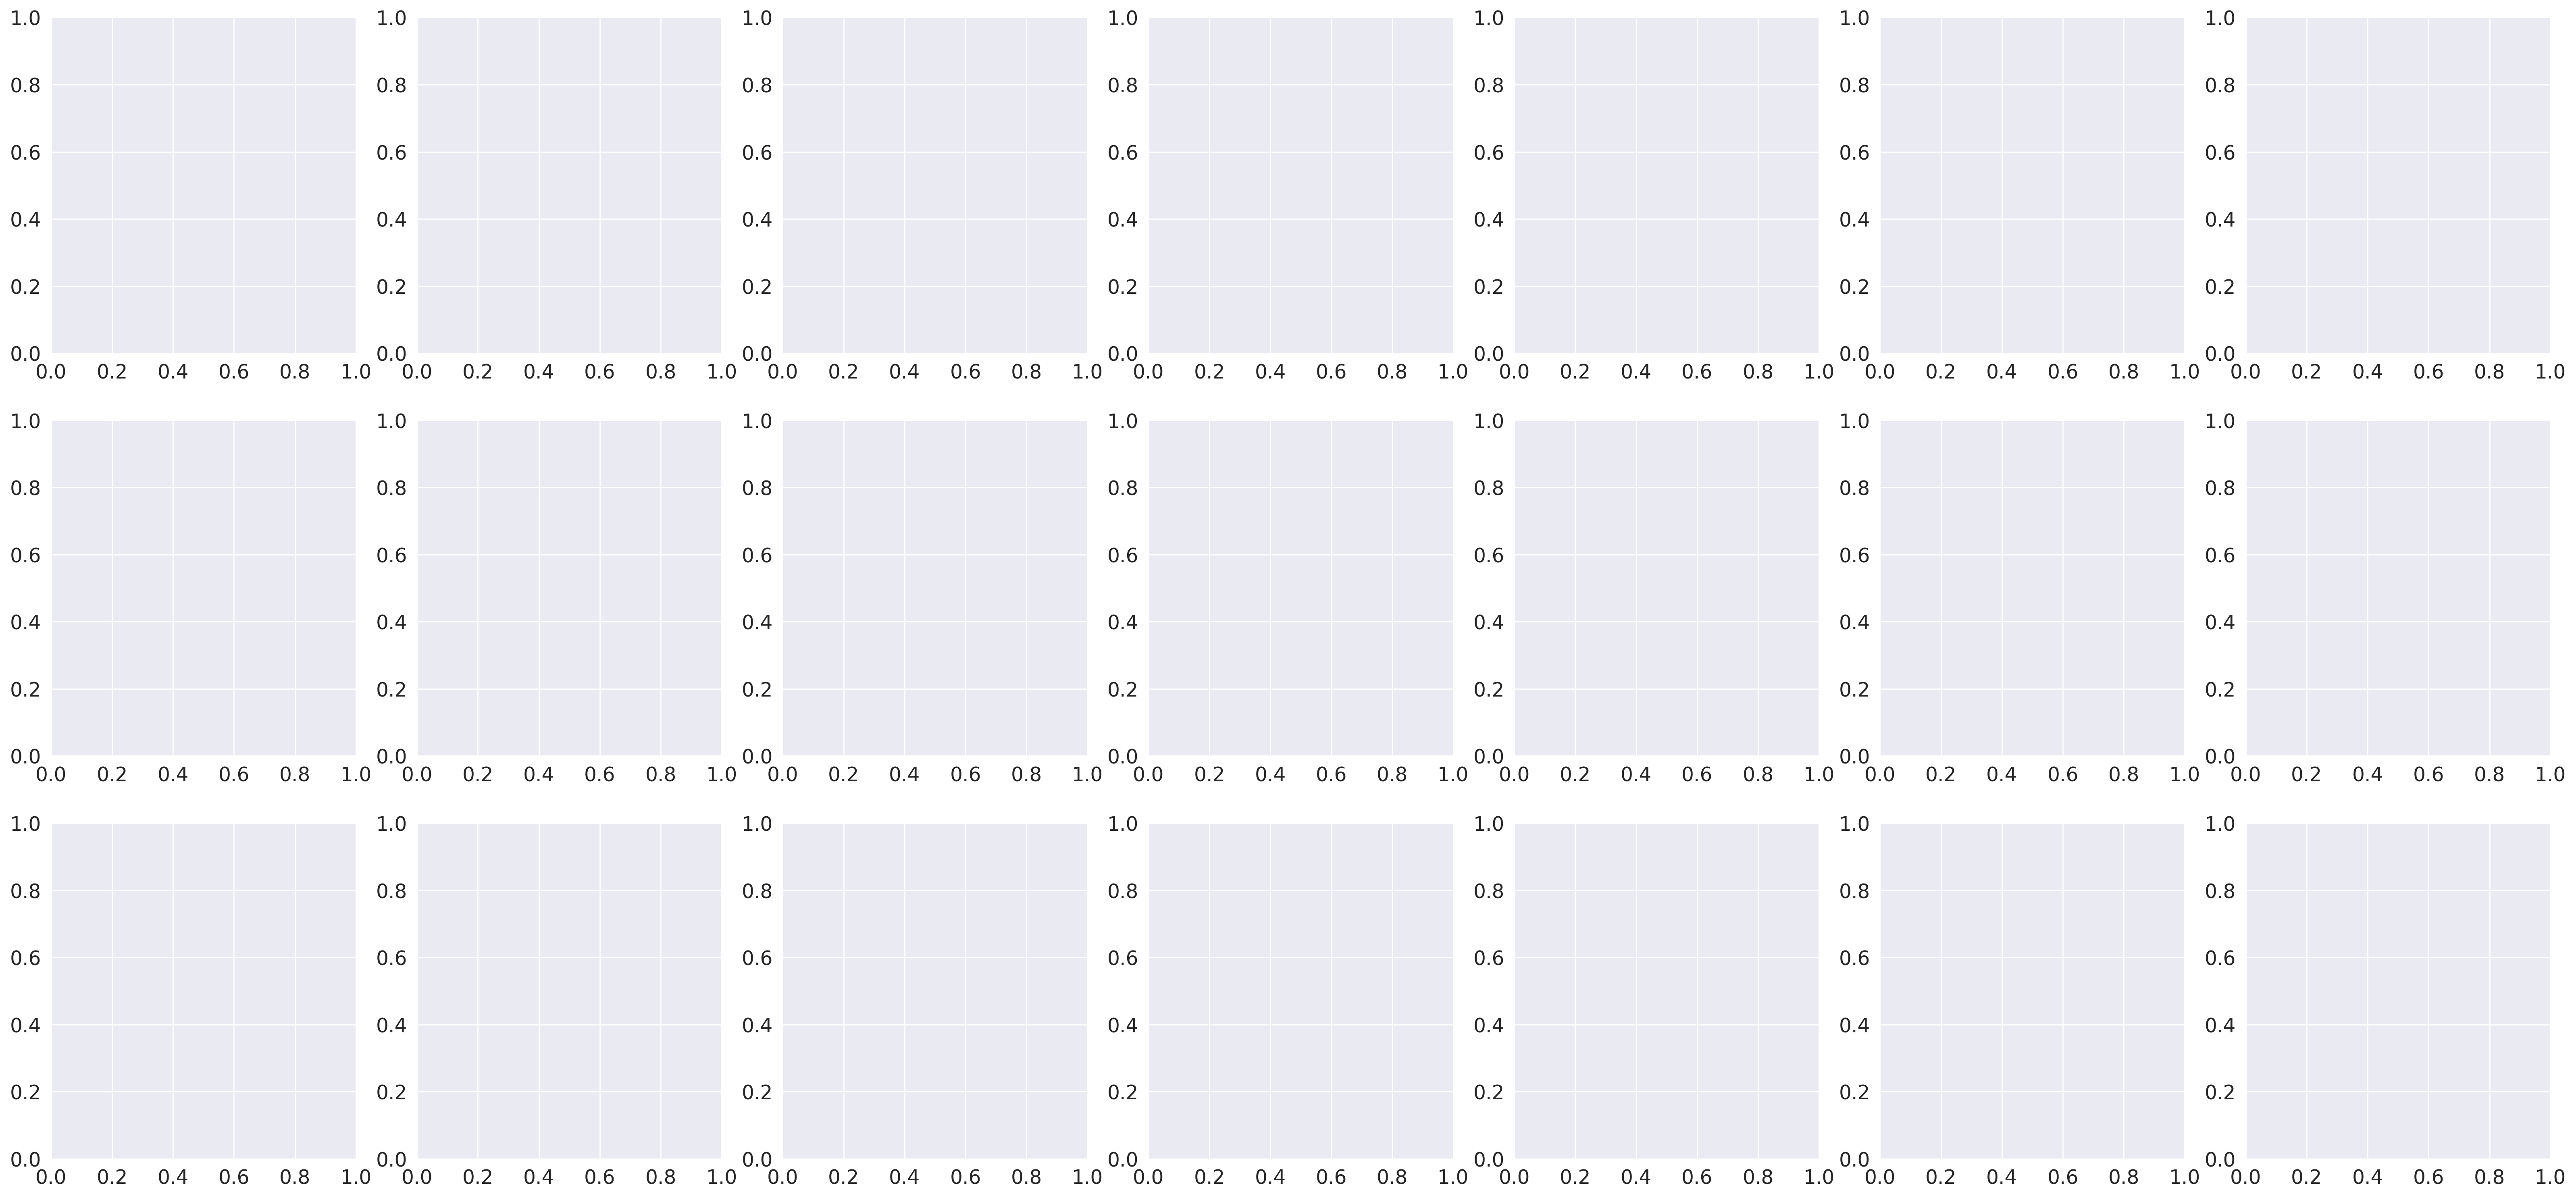

In [17]:
dirs = [Path('/lab/processed-data/ALS0006_NGN2_DIV11_KOv1_MG132/DIV11__2023-02-15T11_31_26-Measurement 1'),
    Path('/lab/processed-data/ALS0006_NGN2_DIV18_KOv1_MG132/DIV18__2023-02-24T08_47_12-Measurement 1'),
    Path('/lab/processed-data/ALS0006_KO01_TDP43_20X/ALS0006_KO01_TDP43_20X_01__2023-03-08T11_11_56-Measurement 1/')]
analysis_name = '2023-02-17_tdp43seg_tdp-43'
measurement = 'Intensity_IntegratedIntensity_TDP43_corrected'
neg_con = 'NT'
concentration = "2"

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (32, 15)
plt.rcParams['font.size'] = 14
NT_color = sns.color_palette('colorblind')[0]
ylims = [[0.3, 1.6], [0.5, 1.8], [0.4, 2]]
# crispr_mutants = ratio_data.query('crispr not in["empty", @neg_con]')['crispr'].unique()
crispr_mutants = ['UNC13A', 'C9ORF72', 'SCFD1', 'RANBP10', 'ZDHHC6', 'ZNF142',
       'RESP18']
fig, axs = plt.subplots(3, len(crispr_mutants))

for i_exp, data_dir in enumerate(dirs):
    plate = Plate(data_dir, analysis_name)
    Plate.reindex_nuclei()
    ratio_data = calculate_ratio(plate, measurement)
    ratio_data = ratio_data.merge(plate.platemap, on='well_position')
    ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()
    # ratio_data = ratio_data.groupby(['well_position', 'crispr', 'treatment', 'concentration']).mean()
    ratio_data = ratio_data.reset_index()
    ratio_data = ratio_data.drop(ratio_data.index[ratio_data['TDP43_ratio'] > 2])

    # pairs = [[(('0', 'NT'), ('0', crispr)), (('2', 'NT'), ('2', crispr))][0] for crispr in crispr_mutants]
    for i_crispr, crispr in enumerate(crispr_mutants):

        data = ratio_data.query('crispr in [@neg_con, @crispr] and concentration in ["0", @concentration]')
        hue = 'crispr'
        x = 'concentration'
        y = 'TDP43_ratio'
        ax = axs[i_exp,i_crispr]
        crispr_color = sns.color_palette('colorblind')[i_crispr+1]
        hue_order = ['NT', crispr]
        sns.boxplot(ax=ax,data=data, x=x, y=y, hue=hue, hue_order=hue_order, palette=[NT_color, crispr_color])
        sns.stripplot(ax=ax,data=data, x=x, y=y, hue=hue,  hue_order=hue_order, dodge=True, linewidth=2, size=10, palette=[NT_color, crispr_color], alpha=0.7)
        ax.set_xticklabels(['DMSO', '+ ' + concentration + 'uM MG132'])
        ax.set_xlabel('')
        ax.legend([])
        ax.set_title(crispr)

        pairs = [(('0', neg_con), ('0', crispr)), ((concentration, neg_con), (concentration, crispr))]
        annot = Annotator(ax, pairs, data=data, x=x, y=y, hue=hue)
        annot.configure(test='t-test_ind', text_format='star',  comparisons_correction='bonferroni')
        annot.apply_test(num_comparisons=len(crispr_mutants)*2)
        ax, test_results = annot.annotate(line_offset_to_group=0.2)
        ax.set_ylim(ylims[i_exp])

plt.subplots_adjust(wspace=0.3, hspace=0.3)
axs[0,0].set_ylabel('DIV11')
axs[1,0].set_ylabel('DIV18')
axs[2,0].set_ylabel('DIV25')

In [18]:
plate.reindex_nuclei()

/tmp/ipykernel_3865/830816011.py:14: RuntimeWarning: invalid value encountered in long_scalars
  ion = (nucleus_img * soma_img).sum() / (nucleus_img).sum()


KeyboardInterrupt: 

In [22]:
len(nucleus_selection)

18

In [23]:
soma_data

,ImageNumber,ObjectNumber,FileName_DAPI,FileName_MAP2,FileName_TDP43,FileName_nuclei_outlines,FileName_soma_outlines,PathName_DAPI,PathName_MAP2,PathName_TDP43,...,RadialDistribution_ZernikePhase_TDP43_corrected_8_0,RadialDistribution_ZernikePhase_TDP43_corrected_8_2,RadialDistribution_ZernikePhase_TDP43_corrected_8_4,RadialDistribution_ZernikePhase_TDP43_corrected_8_6,RadialDistribution_ZernikePhase_TDP43_corrected_8_8,RadialDistribution_ZernikePhase_TDP43_corrected_9_1,RadialDistribution_ZernikePhase_TDP43_corrected_9_3,RadialDistribution_ZernikePhase_TDP43_corrected_9_5,RadialDistribution_ZernikePhase_TDP43_corrected_9_7,RadialDistribution_ZernikePhase_TDP43_corrected_9_9
0,1,1,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch1sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1.570796,2.781264,-2.802162,-1.873104,1.764401,-0.288365,-2.956407,-0.818034,-2.051160,-0.987605
1,1,2,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch1sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1.570796,-2.633591,1.855562,-0.278070,2.130811,-2.478456,1.799989,2.623989,3.096573,-2.871889
2,1,3,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch1sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1.570796,-2.725774,1.227060,-0.457644,-0.746891,-2.694573,-0.603346,-0.089162,-2.619883,1.667113
3,1,4,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch1sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1.570796,-2.155172,2.473096,0.591089,1.935807,2.432233,1.609436,-1.606842,0.329691,0.142361
4,1,5,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch1sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1.570796,-2.068278,-1.849844,-0.544067,1.048856,1.294383,-2.472344,3.019819,0.318530,-1.589541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94310,1152,64,r07c10f24p01-ch3sk1fk1fl1.tiff,r07c10f24p01-ch1sk1fk1fl1.tiff,r07c10f24p01-ch2sk1fk1fl1.tiff,r07c10f24p01-ch3sk1fk1fl1.tiff,r07c10f24p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1.570796,-1.355497,2.216524,-2.953113,-0.876973,1.906770,0.133076,2.576055,0.570569,2.773079
94311,1152,65,r07c10f24p01-ch3sk1fk1fl1.tiff,r07c10f24p01-ch1sk1fk1fl1.tiff,r07c10f24p01-ch2sk1fk1fl1.tiff,r07c10f24p01-ch3sk1fk1fl1.tiff,r07c10f24p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,-1.570796,-2.991288,2.006046,0.683222,2.084406,3.065021,1.734117,1.795677,-2.592216,-2.016938
94312,1152,66,r07c10f24p01-ch3sk1fk1fl1.tiff,r07c10f24p01-ch1sk1fk1fl1.tiff,r07c10f24p01-ch2sk1fk1fl1.tiff,r07c10f24p01-ch3sk1fk1fl1.tiff,r07c10f24p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1.570796,2.587984,1.42

In [7]:
soma_data

,ImageNumber,ObjectNumber,FileName_DAPI,FileName_MAP2,FileName_TDP43,FileName_nuclei_outlines,FileName_soma_outlines,PathName_DAPI,PathName_MAP2,PathName_TDP43,...,RadialDistribution_ZernikePhase_TDP43_corrected_8_0,RadialDistribution_ZernikePhase_TDP43_corrected_8_2,RadialDistribution_ZernikePhase_TDP43_corrected_8_4,RadialDistribution_ZernikePhase_TDP43_corrected_8_6,RadialDistribution_ZernikePhase_TDP43_corrected_8_8,RadialDistribution_ZernikePhase_TDP43_corrected_9_1,RadialDistribution_ZernikePhase_TDP43_corrected_9_3,RadialDistribution_ZernikePhase_TDP43_corrected_9_5,RadialDistribution_ZernikePhase_TDP43_corrected_9_7,RadialDistribution_ZernikePhase_TDP43_corrected_9_9
0,1,1,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch1sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1.570796,2.781264,-2.802162,-1.873104,1.764401,-0.288365,-2.956407,-0.818034,-2.051160,-0.987605
1,1,2,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch1sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1.570796,-2.633591,1.855562,-0.278070,2.130811,-2.478456,1.799989,2.623989,3.096573,-2.871889
2,1,3,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch1sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1.570796,-2.725774,1.227060,-0.457644,-0.746891,-2.694573,-0.603346,-0.089162,-2.619883,1.667113
3,1,4,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch1sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1.570796,-2.155172,2.473096,0.591089,1.935807,2.432233,1.609436,-1.606842,0.329691,0.142361
4,1,5,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch1sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,r02c03f01p01-ch3sk1fk1fl1.tiff,r02c03f01p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1.570796,-2.068278,-1.849844,-0.544067,1.048856,1.294383,-2.472344,3.019819,0.318530,-1.589541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94310,1152,64,r07c10f24p01-ch3sk1fk1fl1.tiff,r07c10f24p01-ch1sk1fk1fl1.tiff,r07c10f24p01-ch2sk1fk1fl1.tiff,r07c10f24p01-ch3sk1fk1fl1.tiff,r07c10f24p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1.570796,-1.355497,2.216524,-2.953113,-0.876973,1.906770,0.133076,2.576055,0.570569,2.773079
94311,1152,65,r07c10f24p01-ch3sk1fk1fl1.tiff,r07c10f24p01-ch1sk1fk1fl1.tiff,r07c10f24p01-ch2sk1fk1fl1.tiff,r07c10f24p01-ch3sk1fk1fl1.tiff,r07c10f24p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,-1.570796,-2.991288,2.006046,0.683222,2.084406,3.065021,1.734117,1.795677,-2.592216,-2.016938
94312,1152,66,r07c10f24p01-ch3sk1fk1fl1.tiff,r07c10f24p01-ch1sk1fk1fl1.tiff,r07c10f24p01-ch2sk1fk1fl1.tiff,r07c10f24p01-ch3sk1fk1fl1.tiff,r07c10f24p01-ch2sk1fk1fl1.tiff,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,/lab/raw-data/ALS0006_NGN2_DIV11_KOv1_MG132/DI...,...,1.570796,2.587984,1.42